In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [1]:
CLASSES = ["Top 10 pct", "Bottom 10 pct", "Top 10 aug", "Top 10 aut"]
SEAS_START, SEAS_END = "2021-08-01", "2024-08-31"
PERIOD = 12     # monthly data

In [4]:
# ───── 1. basic plot (raw, already differenced) ─────────────────────────
df = pd.read_csv("data/output/time_series.csv")
df = df[df["date"] >= SEAS_START].copy()
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)

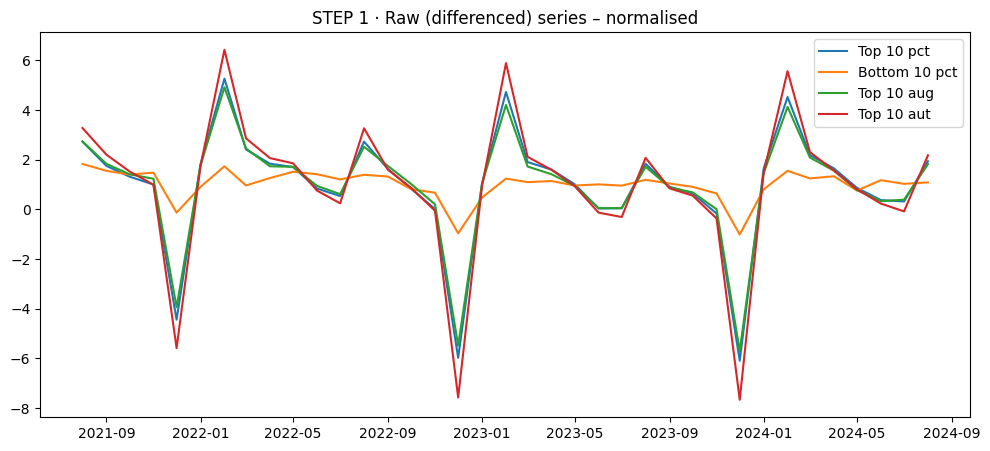

In [5]:

# ────────────────────────────────────────────────────────────────────────
# 1. BASIC PLOT  ▸  raw (normalised) series
# ────────────────────────────────────────────────────────────────────────
df["net_jobs_norm"] = df["net_jobs"] / df.groupby("class")["net_jobs"].transform("mean")

plt.figure(figsize=(12, 5))
for c in CLASSES:
    sub = df[df["class"] == c]
    plt.plot(sub["date"], sub["net_jobs_norm"], label=c)
plt.title("STEP 1 · Raw (differenced) series – normalised")
plt.legend(); plt.show()

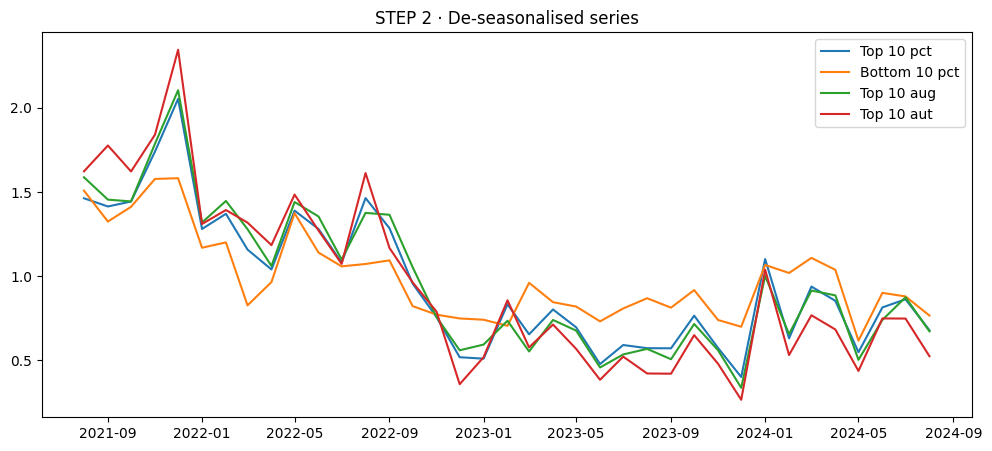

In [6]:
# ───── 2. de-seasonalise via STL (monthly means) ────────────────────────
seasonal = {}
for c in CLASSES:
    m = (df["class"] == c) & df["date"].between(SEAS_START, SEAS_END)
    series = (df.loc[m, ["date", "net_jobs_norm"]]
                .set_index("date")["net_jobs_norm"]
                .asfreq("MS").interpolate())
    stl = STL(series, period=PERIOD).fit()
    seasonal[c] = (stl.seasonal
                   .groupby(stl.seasonal.index.month)
                   .mean())          # 12-value monthly pattern

df["seasonal"] = df.apply(lambda r: seasonal[r["class"]].loc[r["date"].month],
                          axis=1)
df["deseas"]   = df["net_jobs_norm"] - df["seasonal"]

plt.figure(figsize=(12, 5))
for c in CLASSES:
    plt.plot(df.loc[df["class"] == c, "date"],
             df.loc[df["class"] == c, "deseas"], label=c)
plt.title("STEP 2 · De-seasonalised series")
plt.legend(); plt.show()

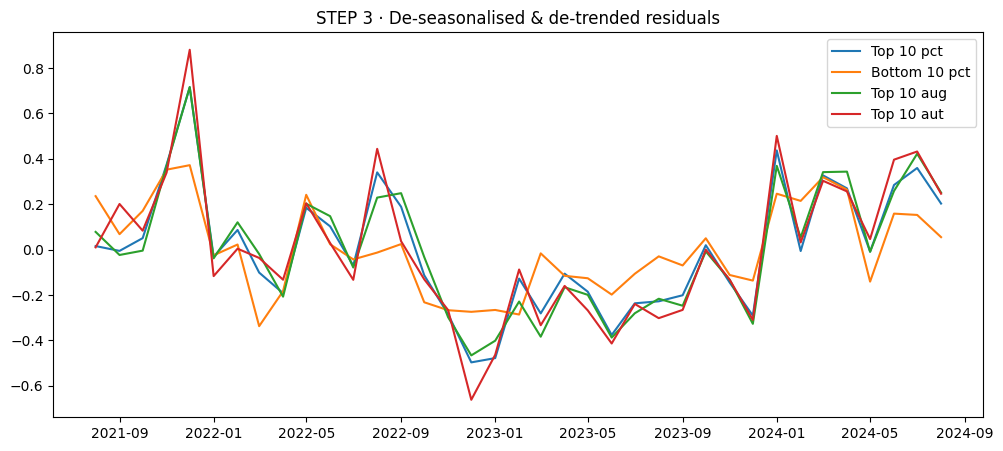

In [7]:
# ───── 3. remove constant / linear drift ─────────────────────
df["t"] = (df["date"] - df["date"].min()).dt.days / 30   # months
results = {}

for c in CLASSES:
    mask, y = df["class"] == c, df.loc[df["class"] == c, "deseas"]
    X = sm.add_constant(df.loc[mask, ["t"]])             # β0 (+β1 t)

    ols = sm.OLS(y, X).fit()
    df.loc[mask, "detrend"] = y - ols.fittedvalues       # u_{c,t}
    results[c] = {"trend": ols}

plt.figure(figsize=(12, 5))
for c in CLASSES:
    plt.plot(df.loc[df["class"] == c, "date"],
             df.loc[df["class"] == c, "detrend"], label=c)
plt.title("STEP 3 · De-seasonalised & de-trended residuals")
plt.legend(); plt.show()

In [9]:
# ───── 4. fit AR(p) on residuals, choose p by AIC 1…6 ───────────────────
for c in CLASSES:
    resid = (df.loc[df["class"] == c, ["date", "detrend"]]
               .set_index("date")["detrend"]
               .asfreq("MS"))          # give AutoReg a proper index

    best_aic, best_p, best_model = np.inf, None, None
    for p in range(1, 7):
        mod = AutoReg(resid, lags=p, old_names=False).fit()
        if mod.aic < best_aic:
            best_aic, best_p, best_model = mod.aic, p, mod

    p_adf = adfuller(resid.dropna())[1]
    print(f"{c:<12} | ADF p={p_adf:.3f} | AR({best_p}) AIC={best_aic:.2f}")

    results[c]["ar"] = best_model

Top 10 pct   | ADF p=0.518 | AR(6) AIC=-0.72
Bottom 10 pct | ADF p=0.013 | AR(1) AIC=-22.87
Top 10 aug   | ADF p=0.021 | AR(6) AIC=-1.61
Top 10 aut   | ADF p=0.666 | AR(6) AIC=7.25
